## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings, json, re, glob, math
# from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 16,
  "EPOCHS": 100,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB4',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-384x384'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 384,
 'WIDTH': 384,
 'CHANNELS': 3,
 'BATCH_SIZE': 16,
 'EPOCHS': 100,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'EfficientNetB4',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'DATASET_PATH': 'melanoma-384x384'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(f"melanoma-{config['HEIGHT']}x{config['WIDTH']}")
GCS_2019_PATH = KaggleDatasets().get_gcs_path(f"isic2019-{config['HEIGHT']}x{config['WIDTH']}")
GCS_MALIGNANT_PATH = KaggleDatasets().get_gcs_path(f"malignant-v2-{config['HEIGHT']}x{config['WIDTH']}")

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=5.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-5.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim, dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


def get_dataset_sampling(files, augment=None, shuffle=False, repeat=False, 
                         labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.001 to 2.45e-05


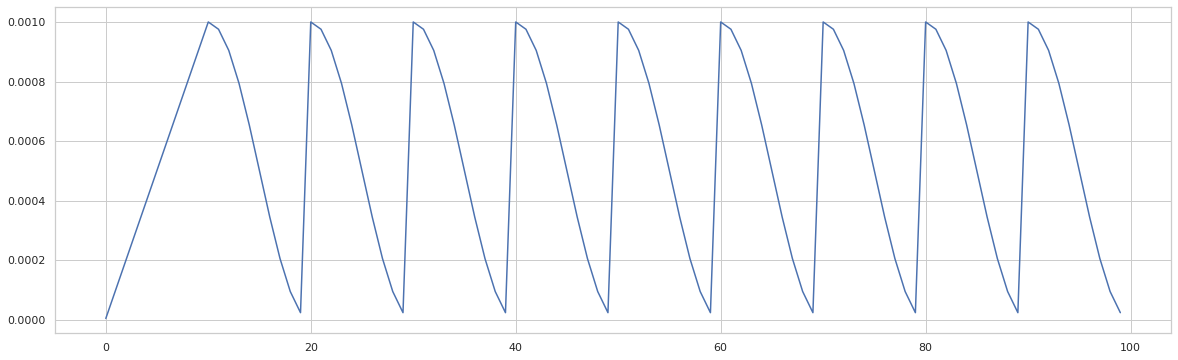

In [8]:
def cosine_with_hard_restarts_schedule_with_warmup(epoch):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function with several hard restarts, after a warmup
    period during which it increases linearly between 0 and 1.
    """
    lr_start   = 5e-6
    lr_max     = config['LEARNING_RATE']
    lr_min     = 1e-6
    warmup_epochs = 10
    num_cycles = 9.
    total_epochs = config['EPOCHS']
    
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(math.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

def get_lr_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cosine_with_hard_restarts_schedule_with_warmup, verbose=False)
    return lr_callback

total_epochs = config['EPOCHS']
rng = [i for i in range(0, total_epochs)]
y = [cosine_with_hard_restarts_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = (584 + 1627) + (581 + 580 + 1614 + 1185)
neg = 32108 + 11232
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
6171
43340
[-1.9492151]
Class weight
{0: 0.38216428241808953, 1: 2.6840058337384542}


In [10]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_image, outputs=output)

    opt = optimizers.Adam(learning_rate=0.001)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

    return model

# Training

In [11]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []; oof_pred_last = []
preds = np.zeros((len(test), 1))
preds_last = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    TRAINING_MALIG_FILENAMES = tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    np.random.shuffle(TRAINING_MALIG_FILENAMES)
    ds_regular = get_dataset_sampling(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                      dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_malig = get_dataset_sampling(TRAINING_MALIG_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    # Resampled TF Dataset
    resampled_ds = tf.data.experimental.sample_from_datasets([ds_regular, ds_malig], weights=[0.6, 0.4])
    resampled_ds = resampled_ds.batch(config['BATCH_SIZE'] * REPLICAS).prefetch(AUTO)

    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    steps_per_epoch = (count_data_items(TRAINING_FILENAMES) / 0.6) / 10
    
    ### MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

    model_path_best_auc = f'model_{fold}_auc.h5'
    model_path_best_loss = f'model_{fold}_loss.h5'
    # model_path_last = f'model_{fold}_last.h5'

    es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], verbose=1)
    checkpoint_auc = ModelCheckpoint(model_path_best_auc, monitor='val_auc', mode='max', save_best_only=True,
                                     save_weights_only=True, verbose=0)
    checkpoint_loss = ModelCheckpoint(model_path_best_loss, monitor='val_loss', mode='min', save_best_only=True,
                                      save_weights_only=True, verbose=0)
    checkpoint_loss.epochs_since_last_save = -10 # Warmup epochs
   
    ### TRAIN
    history = model.fit(resampled_ds, 
                        validation_data=get_dataset(files_valid, augment=None, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=(steps_per_epoch/config['BATCH_SIZE']//REPLICAS), 
                        callbacks=[es, checkpoint_auc, checkpoint_loss, get_lr_callback()], 
                        epochs=config['EPOCHS'], 
                        verbose=2).history
    
    history_list.append(history)
    # Save last model weights
    # model.save_weights(model_path_last)

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                           labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    ### Load best model weights (AUC)
    model.load_weights(model_path_best_auc)
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA (AUC)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred_last.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA (AUC)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds_last[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    ### Load best model weights (Loss)
    model.load_weights(model_path_best_loss)
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA (Loss)...')
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'), axis=1))
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA (Loss)...')
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    ### RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    auc_last = roc_auc_score(oof_tar[-1], oof_pred_last[-1])
    auc_blend = roc_auc_score(oof_tar[-1], np.mean([oof_pred[-1], oof_pred_last[-1]], axis=0))
    oof_val.append(np.max(history['val_auc']))
    print(f'#### FOLD {fold+1} OOF AUC = {oof_val[-1]:.3f}, with TTA (Loss) = {auc:.3f}, with TTA (AUC) = {auc_last:.3f}, with TTA (Blend) = {auc_blend:.3f}')


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/100
47/47 - 45s - loss: 0.6780 - auc: 0.6184 - val_loss: 0.5138 - val_auc: 0.5659 - lr: 5.0000e-06
Epoch 2/100
47/47 - 21s - loss: 0.5104 - auc: 0.8442 - val_loss: 0.2017 - val_auc: 0.6557 - lr: 1.0450e-04
Epoch 3/100
47/47 - 21s - loss: 0.4526 - auc: 0.8876 - val_loss: 0.1784 - val_auc: 0.7468 - lr: 2.0400e-04
Epoch 4/100
47/47 - 21s - loss: 0.4389 - auc: 0.8967 - val_loss: 0.1789 - val_auc: 0.8434 - lr: 3.0350e-04
Epoch 5/100
47/47 - 21s - loss: 0.4276 - auc: 0.9040 - val_loss: 0.2052 - val_auc: 0.8679 - lr: 4.0300e-04
Epoch 6/100
47/47 - 21s - loss: 0.3998 - auc: 0.9212 - val_loss: 0.2127 - val_auc: 0.8899 - lr: 5.0250e-04
Epoch 7/100
47/47 - 21s - loss: 0.3887 - auc: 0.9262 - val_loss: 0.1981 - val_auc: 0.9046 - lr: 6.0200e-04
Epoch 8/100
47/47 - 19s - loss: 0.3535 - auc: 0.9428 - val_loss: 0.2142 - val_auc: 0.8754 - lr: 7.0150e-04
Epoch 9

## Model loss graph

Fold: 1


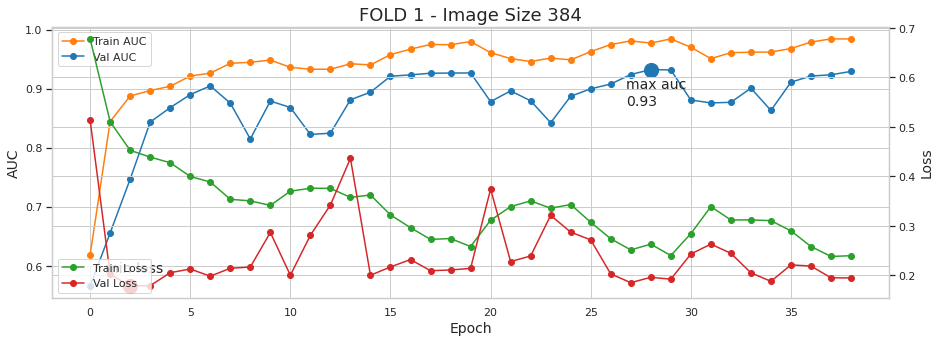

Fold: 2


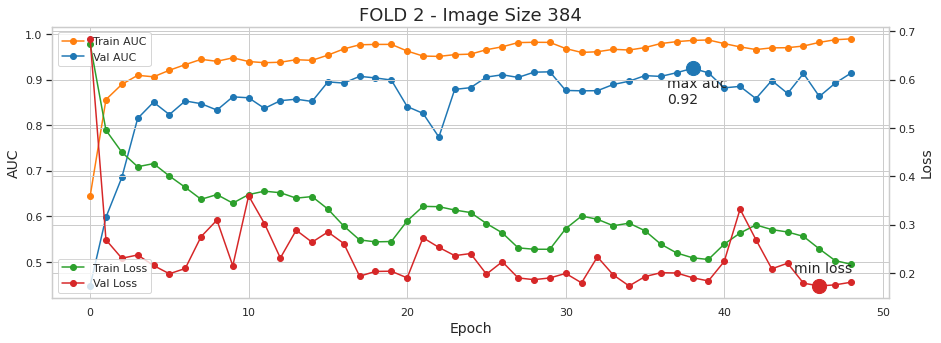

Fold: 3


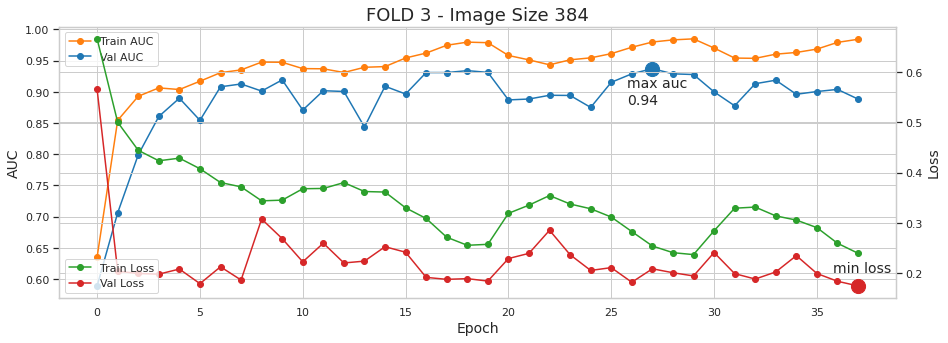

Fold: 4


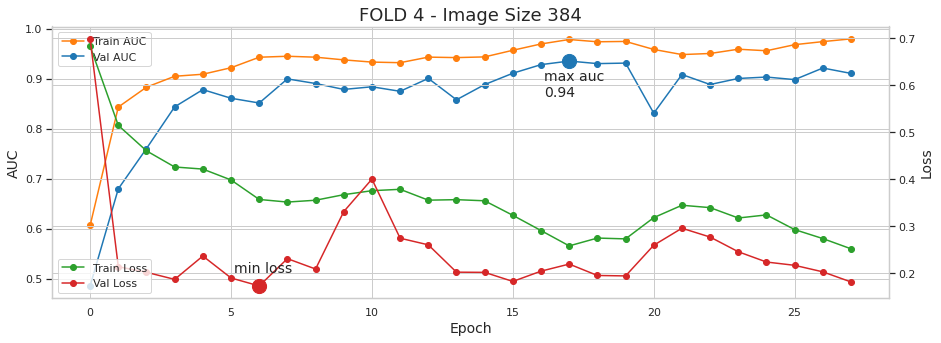

Fold: 5


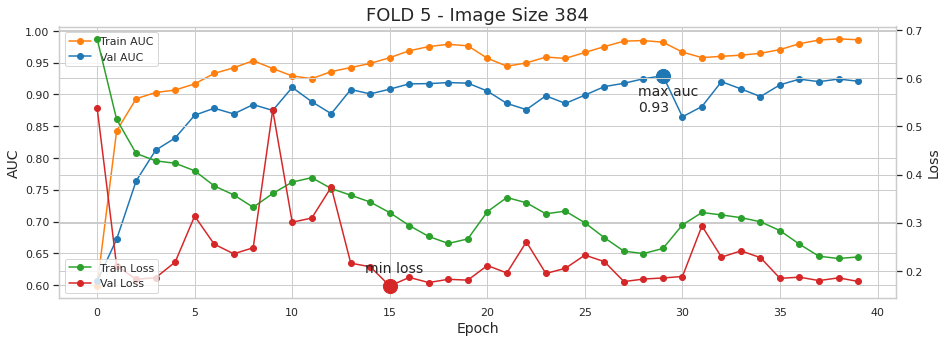

In [12]:
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    epochs = np.arange(len(history['loss']))
    plt.figure(figsize=(15,5))
    plt.plot(epochs, history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(epochs, history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(epochs, history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(epochs, history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

In [13]:
# plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [14]:
# COMPUTE OVERALL OOF AUC
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)

oof = np.concatenate(oof_pred)
oof_last = np.concatenate(oof_pred_last)
oof_blend = np.mean([oof, oof_last], axis=0)

auc = roc_auc_score(true, oof)
auc_last = roc_auc_score(true, oof_last)
auc_blend = roc_auc_score(true, oof_blend)
print(f'Overall OOF AUC with TTA = {auc:.3f}, with TTA (Last) = {auc_last:.3f}, with TTA (Blend) = {auc_blend:.3f}')

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, fold=folds, target=true, pred=oof, 
                           pred_last=oof_last, pred_blend=oof_blend))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.910, with TTA (Last) = 0.934, with TTA (Blend) = 0.933


,image_name,fold,target,pred,pred_last,pred_blend
0,ISIC_2637011,0,0,0.047069,0.047175,0.047122
1,ISIC_0076262,0,0,0.025190,0.019303,0.022246
2,ISIC_0074268,0,0,0.017780,0.014166,0.015973
3,ISIC_0015719,0,0,0.012488,0.010973,0.011731
4,ISIC_0082543,0,0,0.025918,0.018701,0.022309


# Visualize test predictions

Test predictions 205|10777
Test predictions (last) 413|10569
Top 10 samples


,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.021315,0.017356,0.019336
1443,ISIC_0052349,0.025924,0.020576,0.023250
3120,ISIC_0058510,0.026099,0.027951,0.027025
4870,ISIC_0073313,0.022426,0.020288,0.021357
5494,ISIC_0073502,0.024210,0.024596,0.024403
4537,ISIC_0074618,0.023499,0.023058,0.023279
4819,ISIC_0076801,0.051325,0.051395,0.051360
7203,ISIC_0077586,0.044292,0.162849,0.103571
10897,ISIC_0082004,0.096508,0.211091,0.153799
5093,ISIC_0082785,0.035846,0.032485,0.034166


Top 10 positive samples


,image_name,target,target_last,target_blend
2280,ISIC_0112420,0.819223,0.911163,0.865193
2519,ISIC_0208233,0.627574,0.834437,0.731005
9464,ISIC_0220438,0.613992,0.769170,0.691581
1892,ISIC_0274789,0.542862,0.691223,0.617042
4977,ISIC_0351156,0.510541,0.637837,0.574189
1018,ISIC_0391046,0.675683,0.782547,0.729115
8214,ISIC_0470699,0.569052,0.628160,0.598606
10750,ISIC_0481105,0.768588,0.872269,0.820428
8599,ISIC_0535264,0.526335,0.673283,0.599809
7421,ISIC_0539432,0.821130,0.881636,0.851383


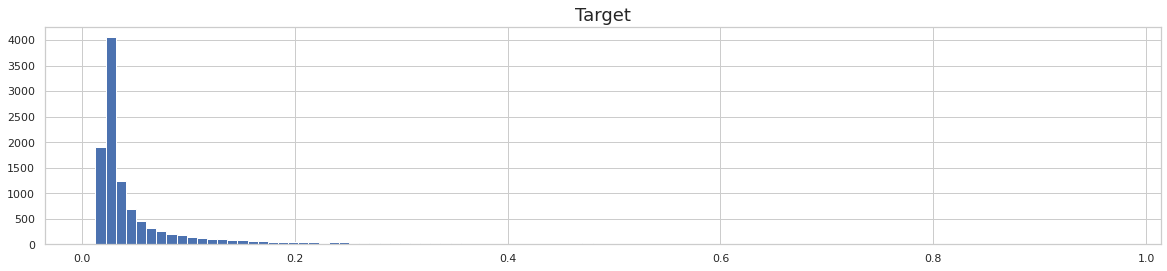

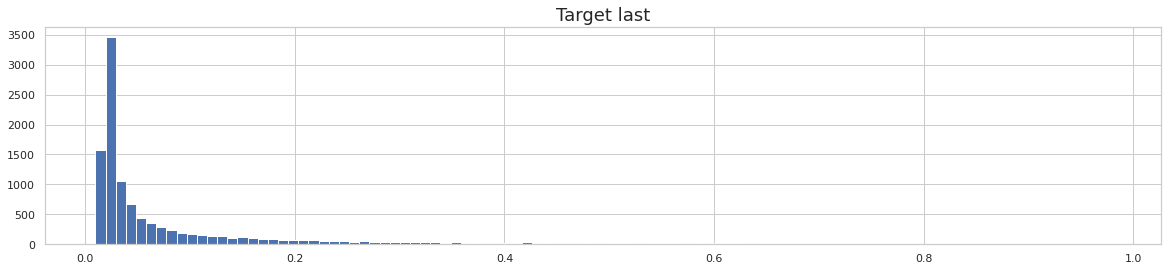

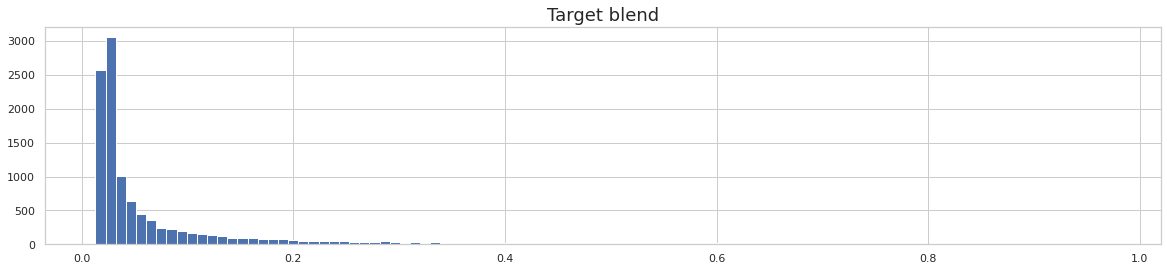

In [15]:
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0], target_last=preds_last[:,0]))
submission['target_blend'] = (submission['target'] * .5) +  (submission['target_last'] * .5)
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")
print(f"Test predictions (last) {len(submission[submission['target_last'] > .5])}|{len(submission[submission['target_last'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target'], bins=100)
plt.title('Target', size=18)
plt.show()

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target_last'], bins=100)
plt.title('Target last', size=18)
plt.show()

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target_blend'], bins=100)
plt.title('Target blend', size=18)
plt.show()

# Test set predictions

In [16]:
display(submission.head(10))
display(submission.describe().T)

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.021315,0.017356,0.019336
1443,ISIC_0052349,0.025924,0.020576,0.023250
3120,ISIC_0058510,0.026099,0.027951,0.027025
4870,ISIC_0073313,0.022426,0.020288,0.021357
5494,ISIC_0073502,0.024210,0.024596,0.024403
4537,ISIC_0074618,0.023499,0.023058,0.023279
4819,ISIC_0076801,0.051325,0.051395,0.051360
7203,ISIC_0077586,0.044292,0.162849,0.103571
10897,ISIC_0082004,0.096508,0.211091,0.153799
5093,ISIC_0082785,0.035846,0.032485,0.034166


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.069656,0.113807,0.012657,0.023470,0.029590,0.057757,0.966000
target_last,10982.0,0.097473,0.152875,0.009767,0.021696,0.032434,0.093852,0.977688
target_blend,10982.0,0.083565,0.131843,0.012878,0.022764,0.031209,0.076242,0.971844
